In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

pd.set_option('display.max_rows', 50)

In [2]:
!ls ../data/nhanes_all/

ls: ../data/nhanes_all/: No such file or directory


In [3]:
# Load
dem = pd.read_csv('../data/nhanes_1994-2018/demographics_clean.csv', index_col=0)
dem = dem[['RIDAGEYR', 'RIAGENDR', 'SEQN', 'SEQN_new']]

# add chemistry
chem = pd.read_csv('../data/nhanes_1994-2018/chemicals_clean.csv', index_col=0)
# LBXSCR = Serum creatinine (mg/dL)'
#
df = dem.merge(chem, how = 'inner', on = ['SEQN', 'SEQN_new'])

# add body measures
response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)
# response = response[['BMXWT', 'BMXHT', 'BMXBMI', 'BMXWAIST', 'SEQN', 'SEQN_new', 'SPPFEV05', 'SPXNFVC',
#                      'BPXSAR', 'LBXSBU', 'LBDHDD', 'LBXSCR', 'LBDSALSI', 'LBXCRP']]
"""
CANDIDATES 

BMXWT # Weight (kg)
BMXHT # Standing Height (cm)
BMXBMI # Body Mass Index (kg/m**2)
BMXWAIST # Waist Circumference (cm)
SPPFEV05 # Forced expiratory volume (mL)
SPXNFVC # Baseline 1st Test Spirometry, Forced Vital Capacity, in mL.
VNAVEBPXSY = Systolic: Average blood pressure (mm Hg)
LBXSCR = Serum creatinine (mg/dL)'
LBXSBU = Serum blood urea nitrogen (mg/dL)
LBDHDD = Serum HDL cholesterol (mg/dL)
LBDSALSI	Serum albumin: SI (g/L)
LBXCRP	Serum C-reactive protein (mg/dL)
"""
df = df.merge(response, how = 'inner', on = ['SEQN', 'SEQN_new'])

# Remove data with too many nans
# df = df[df.columns[df.isna().sum()<70000]]

# Rename columns
dictionary_nhanes = pd.read_csv('../data/nhanes_1994-2018/dictionary_nhanes.csv',index_col=0)
dictionary_nhanes[['variable_codename_use', 'variable_description_use']]
mapping_dict = dict(zip(dictionary_nhanes['variable_codename_use'], dictionary_nhanes['variable_description_use']))
del mapping_dict['SEQN']                     
del mapping_dict['SEQN_new']                     
mapping_dict['RIDAGEYR'] = 'age'
mapping_dict['RIAGENDR'] = 'gender'

df = df.rename(columns=mapping_dict)
df

/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_82945/219444611.py:12: DtypeWarning: Columns (828,829,836,837,846,847,947,948,980,981) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)


,age,gender,SEQN,SEQN_new,SDDSRVYR_x,Serum selenium replicate 2 (ug/L),total Lycopene replicate 1 (ug/dL),total Lycopene replicate 2 (ug/dL),Serum alpha carotene replicate 1 (ug/dL),Serum alpha carotene replicate 2 (ug/dL),...,Serum transferrin receptor (mg/L),Serum uric acid: SI (umol/L),Serum uric acid: SI replicate 1 (umol/L),Serum uric acid: SI replicate 2 (umol/L),Serum uric acid (mg/dL),Serum uric acid replicate 1 (mg/dL),Serum uric acid replicate 2 (mg/dL),N-telopeptides (NTx) (nmol BCE),N-telopeptides (NTx) replicate 1 (nmol BCE),N-telopeptides (NTx) replicate 2 (nmol BCE)
0,21,1,3.0,I-3,-1,NaN,65.0,NaN,5.0,NaN,...,NaN,327.1,327.1,NaN,5.50,5.5,NaN,NaN,NaN,NaN
1,32,2,4.0,I-4,-1,NaN,16.0,NaN,7.0,NaN,...,NaN,166.5,166.5,NaN,2.80,2.8,NaN,NaN,NaN,NaN
2,48,2,9.0,I-9,-1,106.0,18.0,15.0,4.0,4.0,...,NaN,306.3,297.4,315.2,5.15,5.0,5.3,NaN,NaN,NaN
3,35,1,10.0,I-10,-1,NaN,17.0,NaN,5.0,NaN,...,NaN,380.7,380.7,NaN,6.40,6.4,NaN,NaN,NaN,NaN
4,48,1,11.0,I-11,-1,NaN,30.0,NaN,6.0,NaN,...,NaN,249.8,249.8,NaN,4.20,4.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121740,70,2,102952.0,C-102952,10,NaN,NaN,NaN,NaN,NaN,...,2.47,380.7,NaN,NaN,6.40,NaN,NaN,NaN,NaN,NaN
121741,42,1,102953.0,C-102953,10,NaN,NaN,NaN,NaN,NaN,...,2.42,345.0,NaN,NaN,5.80,NaN,NaN,NaN,NaN,NaN
121742,41,2,102954.0,C-102954,10,NaN,NaN,NaN,NaN,NaN,...,21.00,184.4,NaN,NaN,3.10,NaN,NaN,NaN,NaN,NaN
121743,14,2,102955.0,C-102955,10,NaN,NaN,NaN,NaN,NaN,...,4.89,374.7,NaN,NaN,6.30,NaN,NaN,NaN,NaN,NaN


In [280]:
def test_features_for_age_prediction(df):
    results = pd.DataFrame(columns=['Feature', 'R-squared'])
    for feature in tqdm(df.columns):
        if feature in ['age', 'SEQN', 'SEQN_new']: continue 
    
        try:        
            # Select the feature for testing
            X = df[[feature, 'age']].dropna()
            X_feature = X[[feature]]
            y = X['age']
            if 'replicate' in feature: continue
            if len(set(y)) < 60:  # фильтр по кол-ву уникальных возрастов
                print('мало возрастов', feature, len(set(y)))
                continue
            if len(y) < 9000: # фильтр по наличию данных
                print('мало данных', feature, len(y))
                continue
            

            model = LinearRegression()
            model.fit(X_feature, y)
            y_pred = model.predict(X_feature)
            r2 = r2_score(y, y_pred)
            
            feature_results = pd.DataFrame({'Feature': [feature],
                                    'R-squared': [r2],
                                    'non null values': [X.shape[0]]})

            results = pd.concat([results, feature_results], ignore_index=True)
            
        except: pass

    results = results.sort_values(by='R-squared', ascending=False)
    return results

results = test_features_for_age_prediction(df)
results.to_csv('data/1factorr2.csv')
results[:50]

  0%|          | 0/1625 [00:00<?, ?it/s]

/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_26172/2342126761.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, feature_results], ignore_index=True)


мало данных Decanaldehyde (ng/mL) 1411
мало данных Propanaldehyde (ng/mL) 1714
мало данных Butyraldehyde (ng/mL) 1740
мало данных Pentanaldehyde (ng/mL) 1768
мало данных Hexanaldehyde (ng/mL) 1571
мало данных Heptaldehyde (ng/mL) 1527
мало данных Octanaldehyde (ng/mL) 1456
мало данных Nonanaldehyde (ng/mL) 1534
мало данных Benzaldehyde (ng/mL) 1468
мало данных Crotonaldehyde (ng/mL) 1733
мало данных Isopentanaldehyde (ng/mL) 1798
мало данных o-Tolualdehyde (ng/mL) 1561
мало данных 1-Aminonaphthalene, urine (pg/mL) 2478
мало данных 2-Aminonaphthalene, urine (pg/mL) 2488
мало данных 4-Aminobiphenyl, urine (pg/mL) 2492
мало данных o-Anisidine, urine (pg/mL) 2332
мало данных 2,6-Dimethylaniline, urine (pg/mL) 2375
мало данных o-Toluidine, urine (pg/mL) 2412
мало данных 4,4'-Diaminodiphenylmethane (ng/mL) 2831
мало данных 2,4-Diaminotoluene (ng/mL) 2595
мало данных 1,5-Diaminonaphthalene (ng/mL) 2758
мало данных 2,6-Diaminotoluene (ng/mL) 2430
мало данных p-Phenylenediamine (ng/mL) 2608
мал

,Feature,R-squared,non null values
267,Biiliac breadth (cm) (2 years and over),0.498870,26379.0
275,Wrist breadth (cm) (2 years and over),0.420022,26562.0
287,Waist Circumference (cm),0.416689,111013.0
269,Elbow breadth (cm) (2 years and over),0.413424,26567.0
253,Systolic blood pressure average,0.412598,15052.0
249,MIL: maximum inflation levels (mm Hg),0.412469,96927.0
424,"Baseline 1st Test Spirometry, Forced Expirator...",0.412256,20049.0
260,Systolic: Average blood pressure (mm Hg),0.401794,97236.0
268,Buttocks circumference (cm) (2+ years),0.398576,26316.0
254,Systolic: Blood pressure (first reading) mm Hg,0.393711,91754.0


In [272]:
df.isna().sum()

age                                                 0
gender                                              0
SEQN                                                0
SEQN_new                                            0
SDDSRVYR_x                                          0
                                                ...  
Serum uric acid replicate 1 (mg/dL)             96131
Serum uric acid replicate 2 (mg/dL)            119052
N-telopeptides (NTx) (nmol BCE)                110070
N-telopeptides (NTx) replicate 1 (nmol BCE)    116886
N-telopeptides (NTx) replicate 2 (nmol BCE)    121193
Length: 1625, dtype: int64

In [4]:
# SELECT FINAL FEATURES
features = [
    'Waist Circumference (cm)', 
    'Standing Height (cm)',
    'Weight (kg)',
    'Systolic blood pressure average', 
    'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)', 
    'alpha-tocopherol (µg/dL)', 
    'Serum homocysteine: SI (umol/L)', 
    'Serum ferritin (ng/mL)', 
    'Serum creatinine (mg/dL)',
    'Serum blood urea nitrogen (mg/dL)',
    'Serum HDL cholesterol (mg/dL)',
    'Serum albumin:  SI (g/L)', 
    'Serum C-reactive protein (mg/dL)',
    # 'Forced expiratory volume (mL)', 
]

df['Body Mass Index (kg/m**2)'] = (df['Weight (kg)'] / ((df['Standing Height (cm)']*0.01)**2)).round(2)
df['Waist to Height ratio'] = df['Waist Circumference (cm)'] / df['Standing Height (cm)']
features.extend(['Body Mass Index (kg/m**2)', 'Waist to Height ratio'])

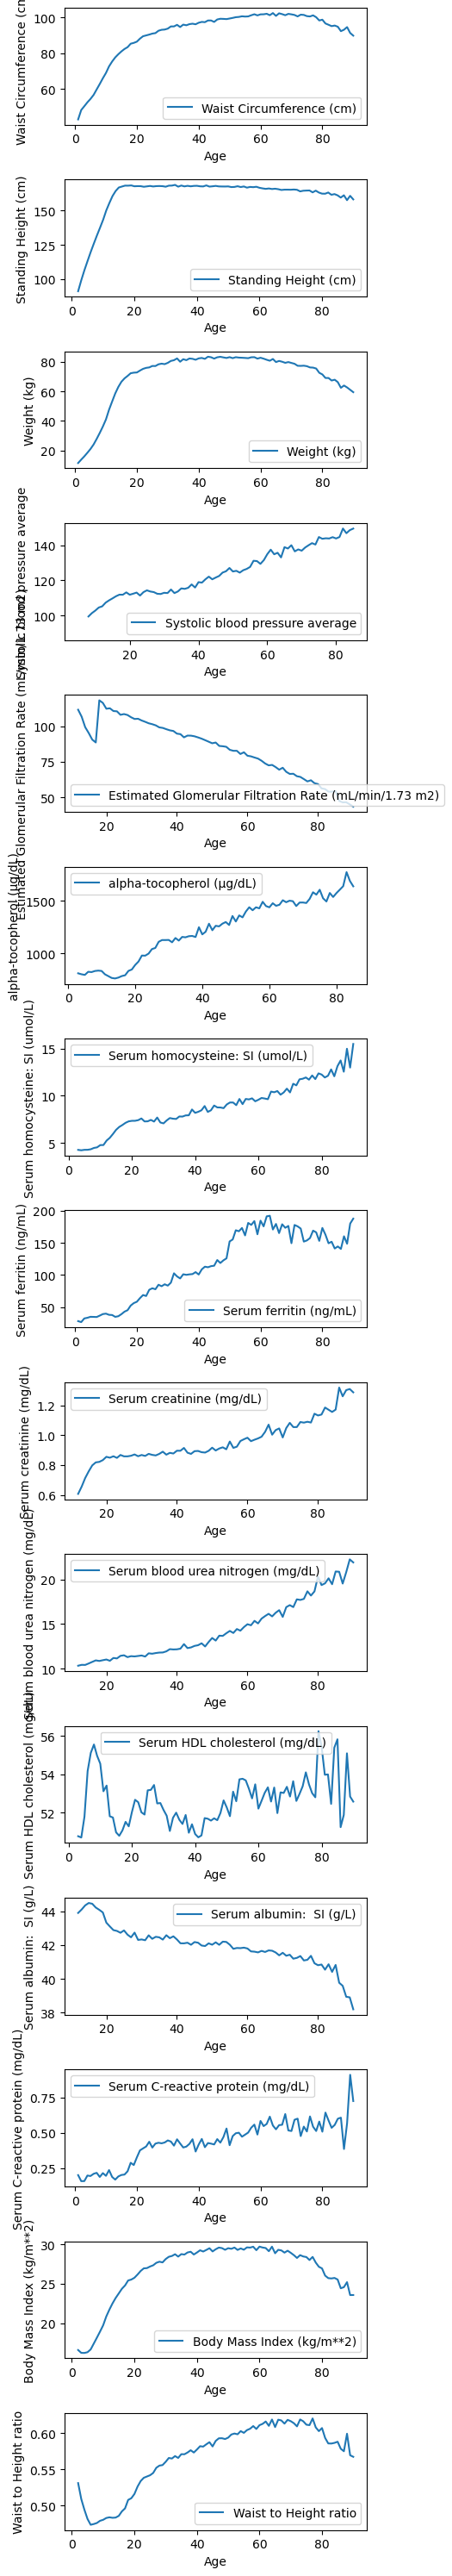

In [5]:

grouped_df = df.groupby('age')[features].mean()

# Plot each feature against age independently
fig, axs = plt.subplots(len(features), 1, figsize=(5, 2*len(features)))  # Adjust the figure size as necessary

for i, feature in enumerate(features):
    axs[i].plot(grouped_df.index, grouped_df[feature], label=feature)
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel(feature)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [6]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# cat_features = demographics_list1_updated[demographics_list1_updated.data_type == 'categorical']['variable_codename_use'].to_numpy()  # Выделяем категориальные признаки
cat_features = []
targets = ["age"]
features2drop = ['SEQN', 'SEQN_new']  # эти фичи будут удалены

X = df[features].drop(targets, axis=1, errors="ignore")
y = df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('y_train.mean()', y_train.mean(), 'y_test.mean()', y_test.mean())

rg = CatBoostRegressor(random_seed=42, custom_metric=['RMSE', 'MAE', 'R2'])#, **params)

rg.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    use_best_model=True,
    plot=True,
    early_stopping_rounds=100,
)

rg.get_feature_importance(prettified=True).head(50)

y_train.mean() age    32.119605
dtype: float64 y_test.mean() age    32.359604
dtype: float64


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,Estimated Glomerular Filtration Rate (mL/min/1...,24.014755
1,Waist Circumference (cm),11.764589
2,Serum blood urea nitrogen (mg/dL),11.402403
3,Serum creatinine (mg/dL),10.145938
4,Weight (kg),8.152676
5,Waist to Height ratio,5.745572
6,Serum ferritin (ng/mL),5.474297
7,alpha-tocopherol (µg/dL),4.921029
8,Standing Height (cm),4.330572
9,Body Mass Index (kg/m**2),3.942138


In [7]:
df[features].isna().sum()

Waist Circumference (cm)                                  10732
Standing Height (cm)                                       5571
Weight (kg)                                                1638
Systolic blood pressure average                          106693
Estimated Glomerular Filtration Rate (mL/min/1.73 m2)     39058
alpha-tocopherol (µg/dL)                                  84792
Serum homocysteine: SI (umol/L)                           84601
Serum ferritin (ng/mL)                                    57949
Serum creatinine (mg/dL)                                  38971
Serum blood urea nitrogen (mg/dL)                         38974
Serum HDL cholesterol (mg/dL)                             23582
Serum albumin:  SI (g/L)                                  38966
Serum C-reactive protein (mg/dL)                          51762
Body Mass Index (kg/m**2)                                  6116
Waist to Height ratio                                     10965
dtype: int64

In [9]:
meta_features = ['gender', 'age', 'SEQN', 'SEQN_new']
df[features + meta_features].to_csv('train_data.csv')

In [10]:
features

['Waist Circumference (cm)',
 'Standing Height (cm)',
 'Weight (kg)',
 'Systolic blood pressure average',
 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)',
 'alpha-tocopherol (µg/dL)',
 'Serum homocysteine: SI (umol/L)',
 'Serum ferritin (ng/mL)',
 'Serum creatinine (mg/dL)',
 'Serum blood urea nitrogen (mg/dL)',
 'Serum HDL cholesterol (mg/dL)',
 'Serum albumin:  SI (g/L)',
 'Serum C-reactive protein (mg/dL)',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio']

# playground

In [92]:
# dem = pd.read_csv('../data/nhanes_1994-2018/demographics_clean.csv', index_col=0)
# dem

,SEQN,SEQN_new,AIALANGA,DMAETHN,DMAETHNR,DMARACE,DMARACER,DMDBORN4,DMDCITZN,DMDEDUC,...,WTMREP43,WTMREP44,WTMREP45,WTMREP46,WTMREP47,WTMREP48,WTMREP49,WTMREP50,WTMREP51,WTMREP52
1,3.0,I-3,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,I-4,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,I-9,NaN,NaN,3.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,I-10,NaN,NaN,3.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11.0,I-11,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135306,102952.0,C-102952,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135307,102953.0,C-102953,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135308,102954.0,C-102954,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135309,102955.0,C-102955,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
# chem = pd.read_csv('../data/nhanes_1994-2018/chemicals_clean.csv', index_col=0)
response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)


/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_26172/1663938094.py:2: DtypeWarning: Columns (828,829,836,837,846,847,947,948,980,981) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)


In [97]:
dictionary_nhanes = pd.read_csv('../data/nhanes_1994-2018/dictionary_nhanes.csv',index_col=0)
dictionary_nhanes

,variable_codename_use,variable_description_use,in_dataset,file_category,num_participants_measurements,unique_cycles,units,cas_num,comment_codename_use,chemical_family,chemical_family_shorten
1,SEQN,Respondent sequence number,Mortality,Survey Variables,135310,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
2,SEQN_new,Respondent sequence number that includes an id...,Mortality,Survey Variables,135310,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
3,ELIGSTAT,Eligibility Status for Mortality Follow-up,Mortality,Mortality,135310,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
4,MORTSTAT,Final Mortality Status,Mortality,Mortality,78663,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
5,UCOD_LEADING,Underlying Cause of Death Recode from UCOD_113...,Mortality,Mortality,17857,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5369,URDPMMLC,Comments code for N-acetyl-s-(3-hydroxypropyl-...,Comments,Volatile Organic Compound (VOC) Metabolites,11243,"2005-2006, 2011-2012, 2013-2014, 2015-2016",NaN,NaN,NaN,NaN,NaN
5370,URDTCVLC,Comments code for N-acetyl-s-(trichlorovinyl)-...,Comments,Volatile Organic Compound (VOC) Metabolites,11269,"2005-2006, 2011-2012, 2013-2014, 2015-2016",NaN,NaN,NaN,NaN,NaN
5371,URDTTCLC,Comments code for 2-thioxothiazolidine-4-carbo...,Comments,Volatile Organic Compound (VOC) Metabolites,8275,"2005-2006, 2011-2012, 2013-2014",NaN,NaN,NaN,NaN,NaN
5372,LBXSZNLC,Comments code for Serum Zinc,Comments,Zinc,7284,"2011-2012, 2013-2014, 2015-2016",NaN,NaN,NaN,NaN,NaN


In [237]:
dictionary_nhanes[dictionary_nhanes['variable_description_use'].astype(str).str.contains('ystolic')]#[['variable_codename_use', 'variable_description_use']].values


,variable_codename_use,variable_description_use,in_dataset,file_category,num_participants_measurements,unique_cycles,units,cas_num,comment_codename_use,chemical_family,chemical_family_shorten
963,BPXSAR,Systolic blood pressure average,Response,Blood Pressure,15052,"1999-2000, 2001-2002",NaN,NaN,NaN,NaN,NaN
964,BPXSY1,Systolic: Blood pressure (first reading) mm Hg,Response,Blood Pressure,91754,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
965,BPXSY11,Systolic: Blood pressure (first reading) repli...,Response,Blood Pressure,23100,1988-1994,NaN,NaN,NaN,NaN,NaN
966,BPXSY12,Systolic: Blood pressure (first reading) repli...,Response,Blood Pressure,1646,1988-1994,NaN,NaN,NaN,NaN,NaN
967,BPXSY2,Systolic: Blood pressure (second reading) mm Hg,Response,Blood Pressure,91099,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
968,BPXSY21,Systolic: Blood pressure (second reading) repl...,Response,Blood Pressure,23087,1988-1994,NaN,NaN,NaN,NaN,NaN
969,BPXSY22,Systolic: Blood pressure (second reading) repl...,Response,Blood Pressure,1648,1988-1994,NaN,NaN,NaN,NaN,NaN
970,BPXSY3,Systolic: Blood pressure (third reading) mm Hg,Response,Blood Pressure,90395,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
971,BPXSY31,Systolic: Blood pressure (third reading) repli...,Response,Blood Pressure,22981,1988-1994,NaN,NaN,NaN,NaN,NaN
972,BPXSY32,Systolic: Blood pressure (third reading) repli...,Response,Blood Pressure,1646,1988-1994,NaN,NaN,NaN,NaN,NaN


In [214]:
dictionary_nhanes[dictionary_nhanes['variable_description_use']=='Serum creatinine']

,variable_codename_use,variable_description_use,in_dataset,file_category,num_participants_measurements,unique_cycles,units,cas_num,comment_codename_use,chemical_family,chemical_family_shorten


In [133]:
dictionary_nhanes['in_dataset'].value_counts()

in_dataset
Questionnaire    1445
Response         1029
Weights           965
Chemicals         599
Comments          505
Demographics      389
Dietary           324
Occupation         73
Medications        29
Mortality          15
Name: count, dtype: int64

In [152]:
response.columns.value_counts()

Has a doctor or other health professional ever told {you/SP}that {you/he/she} had . . .    5
Serum triglycerides (mg/dL)                                                                2
Serum total cholesterol replicate 1 (mg/dL)                                                2
Serum total cholesterol (mg/dL)                                                            2
Serum triglycerides:  SI replicate 2 (mmol/L)                                              2
                                                                                          ..
Waist to hip ratio replicate 1                                                             1
Waist to hip ratio replicate 2                                                             1
Wrist breadth (cm) (2 years and over)                                                      1
Wrist breadth replicate 1 (cm) (2 years and over)                                          1
N-telopeptides (NTx) replicate 2 (nmol BCE)                           

In [159]:
dictionary_nhanes['file_category'].value_counts()[:20]

file_category
Survey Weights - Chemicals                     595
Medical Conditions                             573
Demographics                                   388
Survey Weights                                 370
Vitamin, Mineral, and Medicine Usage           192
Dioxins, Furans, & Coplanar PCBs               175
Volatile Organic Compound (VOC) Metabolites    168
Total Nutrient Intakes                         164
Reproductive Health                            156
Complete Blood Count                           150
Body Measures                                  127
Bioelectrical Impedance Analysis               124
Physical Activity                              113
Spirometry                                     103
Diabetes                                        86
Food Frequency                                  81
Vitamin A, Vitamin E & Carotenoids              76
Blood Pressure                                  75
Occupation                                      70
Fish & Shellfish 